In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import joblib
seed=42
np.random.seed(seed)
%matplotlib inline
pd.set_option('display.max_rows', 100)  # You can increase this number as needed

In [2]:
# Load dataset
df = pd.read_csv('../data/ames_transactions__2_.csv')

df.head()

,property_id,dwelling_subclass,zoning_type,lot_frontage_ft,lot_area_sq_ft,street_type,alley_type,lot_shape,land_contour,utilities,...,fence_quality_rating,misc_feature,misc_value,month_sold,year_sold,sale_type,sale_condition,sale_price,longitude,latitude
0,0526301100,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Fence,NaN,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,0526350040,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,Minimum_Privacy,NaN,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,0526351010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,0526353030,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,No_Fence,NaN,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,0527105010,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,Minimum_Privacy,NaN,0,3,2010,WD,Normal,189900,-93.638933,42.060899


In [3]:
# Number of data samples and features
print("Number of data samples:", df.shape[0])
print("Number of features:", df.shape[1])

#The data has 82 columns which include 
# 23 nominal, 
# 23 ordinal, 
# 14 discrete, 
# and 20 continuous variables 
# (and 2 additional observation identifiers)

Number of data samples: 2930
Number of features: 82


In [4]:
summary = []

for col in df.columns:
    dtype = df[col].dtype
    unique_count = df[col].nunique()
    null_count = df[col].isnull().sum()
    top_vals = df[col].value_counts().head(4)
    
    # Fill with NaN if less than 4 unique values
    top_keys = list(top_vals.index) + [None] * (4 - len(top_vals))
    top_counts = list(top_vals.values) + [None] * (4 - len(top_vals))

    summary.append({
        'Column': col,
        'Dtype': dtype,
        'Unique': unique_count,
        'Nulls': null_count,
        'Top1': top_keys[0],
        'Top1_Count': top_counts[0],
        'Top2': top_keys[1],
        'Top2_Count': top_counts[1],
        'Top3': top_keys[2],
        'Top3_Count': top_counts[2],
        'Top4': top_keys[3],
        'Top4_Count': top_counts[3],
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

,Column,Dtype,Unique,Nulls,Top1,Top1_Count,Top2,Top2_Count,Top3,Top3_Count,Top4,Top4_Count
0,property_id,object,2930,0,0526301100,1,0535375130,1,0535378080,1.0,0535379060,1.0
1,dwelling_subclass,object,16,0,One_Story_1946_and_Newer_All_Styles,1079,Two_Story_1946_and_Newer,575,One_and_Half_Story_Finished_All_Ages,287.0,One_Story_PUD_1946_and_Newer,192.0
2,zoning_type,object,7,0,Residential_Low_Density,2273,Residential_Medium_Density,462,Floating_Village_Residential,139.0,Residential_High_Density,27.0
3,lot_frontage_ft,int64,129,0,0,490,60,276,80,137.0,70,133.0
4,lot_area_sq_ft,int64,1960,0,9600,44,7200,43,6000,34.0,9000,29.0
5,street_type,object,2,0,Pave,2918,Grvl,12,None,NaN,None,NaN
6,alley_type,object,3,0,No_Alley_Access,2732,Gravel,120,Paved,78.0,None,NaN
7,lot_shape,object,4,0,Regular,1859,Slightly_Irregular,979,Moderately_Irregular,76.0,Irregular,16.0
8,land_contour,object,4,0,Lvl,2633,HLS,120,Bnk,117.0,Low,60.0
9,utilities,object,3,0,AllPub,2927,NoSewr,2,NoSeWa,1.0,None,NaN


## notes:
### - There are a lot of categorical variables (ordinal & nominal). House values are more subjective than based on raw numbers.
### - non quantitative features are just as important in determining house prices

In [5]:
## additional features

# total built up area
df['total_sq_ft'] = df['first_flr_sq_ft'] + df['second_flr_sq_ft'] + df['total_bsmt_sq_ft']

# total finished built up area
df['total_finished_sq_ft'] = df['first_flr_sq_ft'] + df['second_flr_sq_ft'] + df['total_bsmt_sq_ft'] - df['bsmt_unf_sq_ft']

# total built up area
df['total_bath_count'] = df['full_bath_count'] + df['half_bath_count']

## Pre-processing

In [6]:
class Preprocess:
    
    def __init__(self,X):
        self.processed_df = None
        self.preprocessor = None
        self.encode(X)
    
    def encode(self,X):
        """
        Encodes categorical and numerical features
        """
        df=X
        df['masonry_veneer_type'].fillna("none")
        df['misc_feature'].fillna("none")
        numeric_features = df._get_numeric_data().columns
        cat_features = list(set(df.columns) - set(numeric_features))
        numeric_transformer = Pipeline(
            steps=[("scaler", StandardScaler())
            ])
        categorical_transformer = Pipeline(
            steps=[
                ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
            ])
#        df = df.dropna(subset=cat_features)
        preprocessor = ColumnTransformer(
            transformers=[
                ("numerical", numeric_transformer, numeric_features),
                ("categorical", categorical_transformer, cat_features),
            ])
        preprocessor.set_output(transform='pandas')
        temp = preprocessor.fit_transform(df)
        self.processed_df = temp
        self.preprocessor = preprocessor

In [7]:


# 1. Separate features and target
X = df.drop(['property_id','sale_price'], axis=1)
y = df['sale_price']

# 2. Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

In [8]:
preprocessor = Preprocess(X_train).preprocessor

# Save preprocessor
joblib.dump(preprocessor, '../models/preprocessor.pkl')

['../models/preprocessor.pkl']

## model training

In [9]:
# Transform training and test data
# Load preprocessor
preprocessor = joblib.load('../models/preprocessor.pkl')
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [10]:
# Define models and parameter grids
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=seed),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=seed),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=seed, objective='reg:squarederror'),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    }
}

results = {}

# Grid search for each model
for name, cfg in models.items():
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(cfg['model'], cfg['params'], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train_preprocessed, y_train)
    y_pred = grid.predict(X_test_preprocessed)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'rmse': rmse,
        'mape':mape
    }
    # save model
    joblib.dump(grid.best_estimator_, f'../models/{name}.pkl')

# Show results and feature importances
for name, res in results.items():
    print(f"\n{name}:\n  - Best RMSE: {res['rmse']:.4f}\n  - Best MAPE: {res['mape']:.4f}")
    print(f"Best Params: {res['best_params']}")

Running GridSearchCV for RandomForest...
Running GridSearchCV for GradientBoosting...
Running GridSearchCV for XGBoost...

RandomForest:
  - Best RMSE: 25628.7031
  - Best MAPE: 0.0849
Best Params: {'max_depth': 20, 'n_estimators': 300}

GradientBoosting:
  - Best RMSE: 24458.1506
  - Best MAPE: 0.0788
Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}

XGBoost:
  - Best RMSE: 23810.6911
  - Best MAPE: 0.0782
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [11]:
# model = RandomForestRegressor()
# model.fit(X_train_preprocessed, y_train)
# # save model
# joblib.dump(model, '../models/random_forest_regressor.pkl')

## Feature importance of different attributes

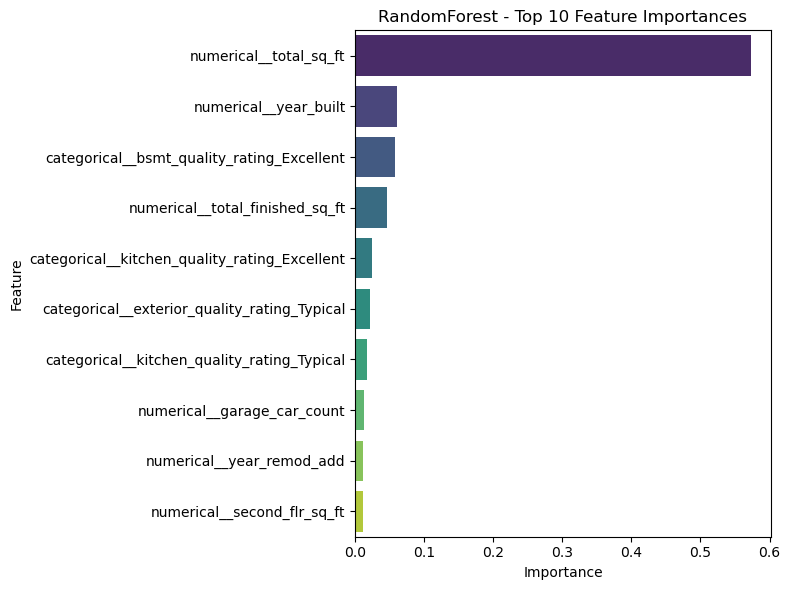

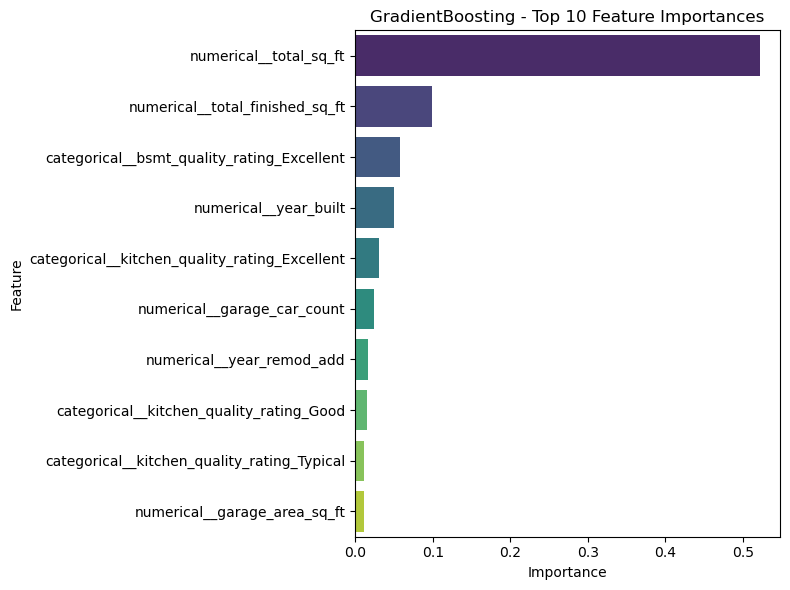

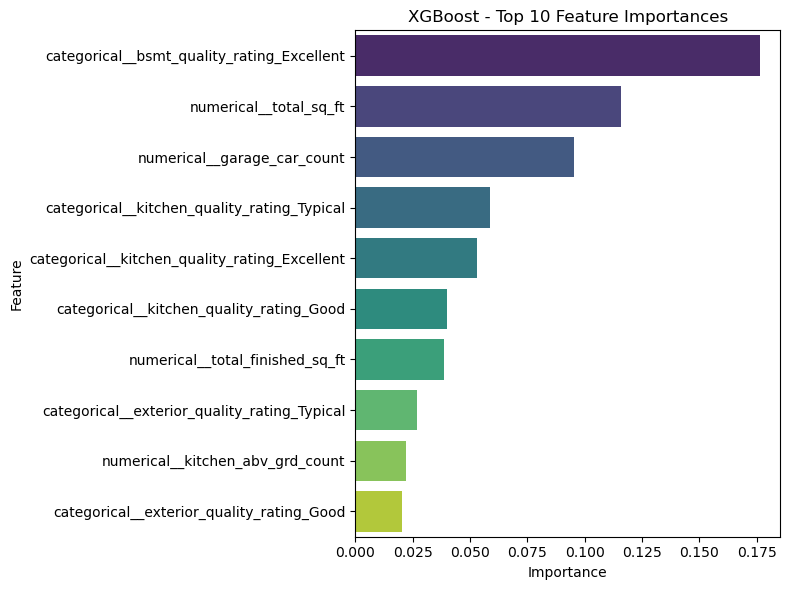

In [12]:
def plot_feature_importance(model, model_name, feature_names, top_n=10):
    if not hasattr(model, "feature_importances_"):
        print(f"{model_name} does not support feature importances.")
        return
    
    importances = model.feature_importances_
    fi = pd.Series(importances, index=feature_names)
    top_features = fi.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title(f"{model_name} - Top {top_n} Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Plot for each model
for name, res in results.items():
    plot_feature_importance(res['best_model'], name, X_train_preprocessed.columns)

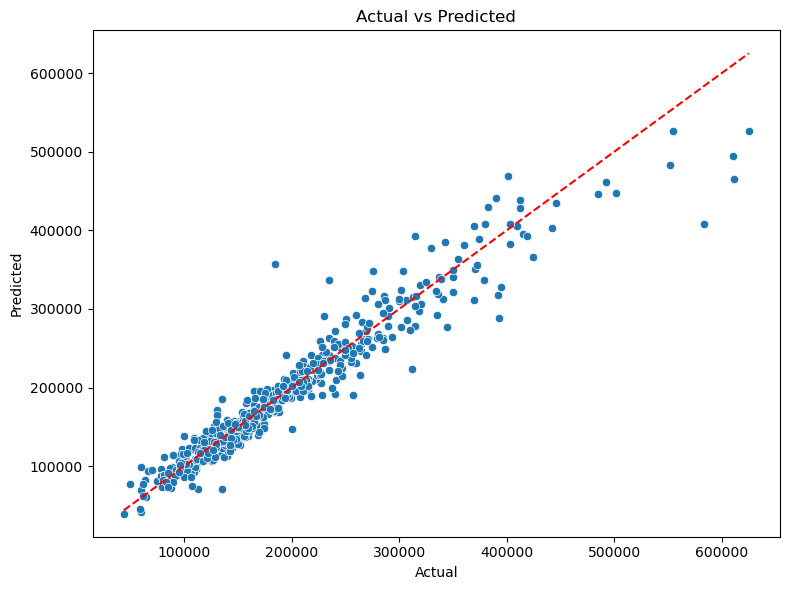

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()

## observations:
- model struggles to predict for high value houses, as there are fewer training samples

In [14]:

test_results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'error': y_test - y_pred,
    'abs_error': abs(y_test - y_pred),
    'percent_error':abs(y_test - y_pred)/y_test
})

# Segment by actual value percentiles
test_results['segment'] = pd.qcut(test_results['actual'], q=4, labels=['Low', 'Med-Low', 'Med-High', 'High'])

# Analyze error per segment
segment_summary = test_results.groupby('segment')['percent_error'].agg(['mean', 'count'])
print(segment_summary)

              mean  count
segment                  
Low       0.104447    148
Med-Low   0.065316    147
Med-High  0.059475    144
High      0.083148    147


## model usage

In [15]:
#load model
model = joblib.load('../models/XGBoost.pkl')

In [16]:
model.predict(X_test_preprocessed)

array([156623.36 , 106507.01 , 194185.45 , 132093.84 , 118693.91 ,
       185131.55 , 147374.23 , 147148.8  ,  99349.86 , 405827.25 ,
       262516.34 , 224908.6  ,  79834.89 , 123724.39 , 107965.805,
       167467.98 , 149321.84 , 188831.27 , 126633.195, 147247.56 ,
       191169.5  , 133785.4  , 203078.64 , 210880.64 , 192960.69 ,
       311131.78 , 317518.22 , 241049.52 , 187174.05 , 206391.55 ,
       184840.16 ,  98155.125, 218032.02 ,  94128.46 , 112742.055,
        80982.99 , 189942.61 , 322263.3  , 193470.66 , 292551.53 ,
       384680.5  , 192260.64 , 215704.   , 196559.58 , 111375.984,
       340858.22 , 168465.77 , 145024.98 , 162821.67 , 127991.32 ,
       181359.92 , 140174.36 , 140017.58 , 153602.89 , 205725.27 ,
       189232.7  , 191602.8  , 136105.33 , 233463.84 , 142568.52 ,
        41338.184, 132361.25 ,  85661.31 , 341001.22 , 248637.25 ,
       169023.39 , 132225.   , 209116.92 , 157693.17 , 186289.6  ,
       162417.52 , 201338.73 , 297237.75 ,  81294.26 , 130039.